In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD,Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Kaggle API setup
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump({"username":"maxprodigy","key":"6d1fee4aa3c6b826476dbd37f1bf33f2"}, f)
!chmod 600 /root/.kaggle/kaggle.json

# Install and upgrade Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

# Download competition data
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025
!mkdir -p "/content/data"
!unzip -oq "assignment-1-time-series-forecasting-may-2025.zip" -d "/content/data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=ed28c33cb4a365afa1bccfcaf9bade42f981772e0e92c891623b1454651f36b7
  Stored in directory: /root/.cache/pip/wheels/b5/23/bd/d33cbf399584fa44fa049711892d333954a50ed4b86948109e
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 839k/839k [00:00<00:00, 1.70MB/s]
100% 839k/839k [00:00<00:00, 1.70MB/s]
/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [6]:
# Load the data
train = pd.read_csv("/content/train.csv")
print("Training data shape:", train.shape)
train.head()

Training data shape: (30676, 12)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [7]:
test = pd.read_csv('/content/test.csv')
print("Test data shape:", test.shape)
test.head()

Test data shape: (13148, 11)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096
1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096
2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096
3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096
4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096


In [8]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [9]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

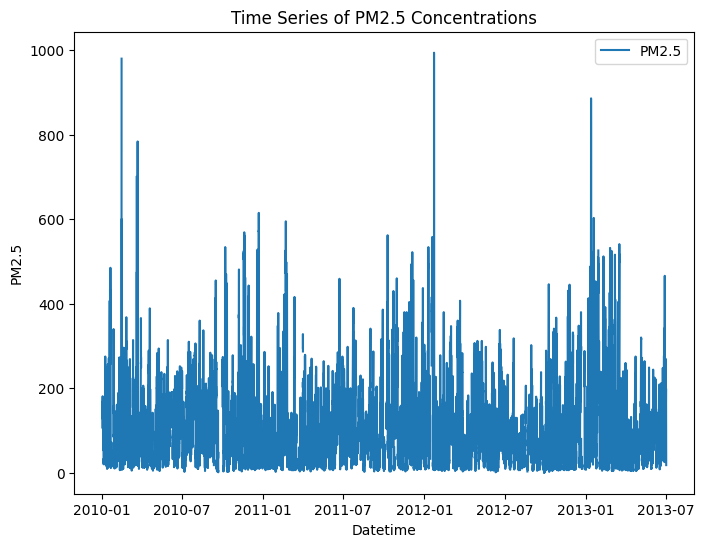

In [10]:
# Visualization: Time series trend for PM2.5
plt.figure(figsize=(8, 6))
# Plot using the DataFrame's index for datetime and access 'pm2.5' from df_train
plt.plot(train.index, train['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [11]:
# Checking for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())


Missing values in training data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


In [12]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [ ]:

from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler




FEATURE ENGINEERING

In [15]:
# Get new featurs from the index
for df in [train, test]:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['season'] = (df.index.month % 12 + 3) // 3

# Neural networks struggle with cyclical features like hour/month,
# cyclical encoding as sine/cosine is crucial for them to understand cycles, that hour 23 is close to hour 0
for df in [train, test]:
    # Hour cyclical encoding (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Month cyclical encoding (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Day of week cyclical encoding (7-day cycle)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

    # Day of month cyclical encoding (approximate 30-day cycle)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 30)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 30)

In [16]:
train

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,...,weekday,season,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-01 23:00:00,30672,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,-0.690542,-0.732019,-0.522096,...,0,3,-0.258819,0.965926,-0.5,-0.866025,0.000000,1.000000,0.207912,0.978148
2013-07-02 00:00:00,30673,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,1.448138,-0.732019,-0.522096,...,1,3,0.000000,1.000000,-0.5,-0.866025,0.781831,0.623490,0.406737,0.913545
2013-07-02 01:00:00,30674,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,1.448138,-0.732019,-0.522096,...,1,3,0.258819,0.965926,-0.5,-0.866025,0.781831,0.623490,0.406737,0.913545


In [18]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

# Standard Scaler

In [21]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [22]:
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)

In [24]:
# Train-test split for validation
from sklearn.model_selection import train_test_split
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [28]:
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
model = Sequential()
model.add(InputLayer((X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(
    Bidirectional(
        LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.15)
    )
)
model.add(
    Bidirectional(
        LSTM(64, return_sequences=False, dropout=0.25, recurrent_dropout=0.15)
    )
)
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1))

model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0005),
    metrics=[RootMeanSquaredError()]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 1, 256)         │       154,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,577 (1.23 MB)

 Trainable params: 321,577 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - loss: 0.9144 - root_mean_squared_error: 0.9556 - val_loss: 0.6426 - val_root_mean_squared_error: 0.8016 - learning_rate: 5.0000e-04
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.7010 - root_mean_squared_error: 0.8372 - val_loss: 0.5954 - val_root_mean_squared_error: 0.7716 - learning_rate: 5.0000e-04
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.6866 - root_mean_squared_error: 0.8284 - val_loss: 0.5544 - val_root_mean_squared_error: 0.7446 - learning_rate: 5.0000e-04
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.6764 - root_mean_squared_error: 0.8224 - val_loss: 0.5674 - val_root_mean_squared_error: 0.7532 - learning_rate: 5.0000e-04
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.6605 - root_mean_squared_error: 0.8126 - val_loss: 0.5545 - val_root_mean_squared_error: 0.7447 - learning_rate: 5.0000e-04
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - l

959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


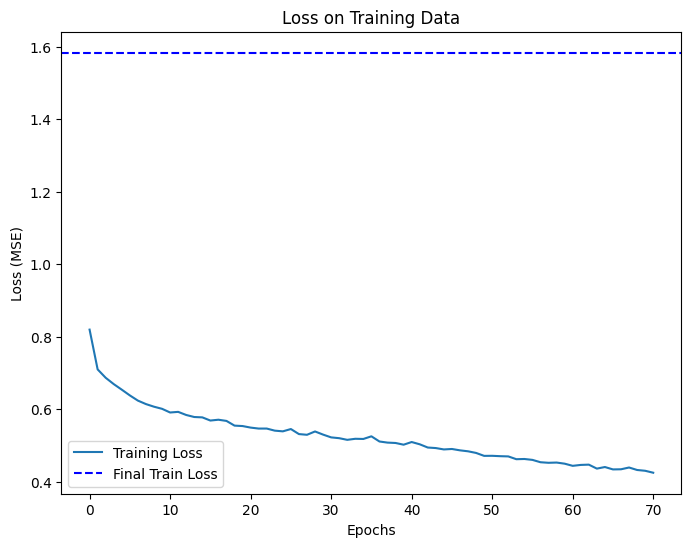

Final Training Loss (MSE): 1.5836488588535536


In [31]:
# Calculate training loss
train_predictions = model.predict(X_train_scaled)  # Use scaled X data
train_loss = np.mean((y_train_scaled - train_predictions.flatten())**2)  # Use scaled y data

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')  # Fixed typo: "rain" -> "Train"
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [35]:
# Prepare test data
X_test = test.drop(['No'], axis=1)
X_test_scaled = x_scaler.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test_scaled)

# transform to correct scale
predictions = y_scaler.inverse_transform(predictions)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/subm_fixed77.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
